In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('../data/processed_data.csv', parse_dates=['date'], index_col='date')

# Handle missing values
df.dropna(inplace=True)

# Normalize data (key for distance-based models)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['Appliances', 'T_out', 'lights', 'RH_1']]),
                         columns=['Appliances', 'T_out', 'lights', 'RH_1'],
                         index=df.index)

print(df_scaled)

                     Appliances     T_out    lights      RH_1
date                                                         
2016-01-11 17:00:00    0.046729  0.372990  0.428571  0.566187
2016-01-11 17:10:00    0.046729  0.369239  0.428571  0.541326
2016-01-11 17:20:00    0.037383  0.365488  0.428571  0.530502
2016-01-11 17:30:00    0.037383  0.361736  0.571429  0.524080
2016-01-11 17:40:00    0.046729  0.357985  0.571429  0.531419
...                         ...       ...       ...       ...
2016-05-27 17:20:00    0.084112  0.891747  0.000000  0.537657
2016-05-27 17:30:00    0.074766  0.887460  0.000000  0.536006
2016-05-27 17:40:00    0.242991  0.883173  0.142857  0.538666
2016-05-27 17:50:00    0.383178  0.878885  0.142857  0.549491
2016-05-27 18:00:00    0.392523  0.874598  0.142857  0.538758

[19735 rows x 4 columns]


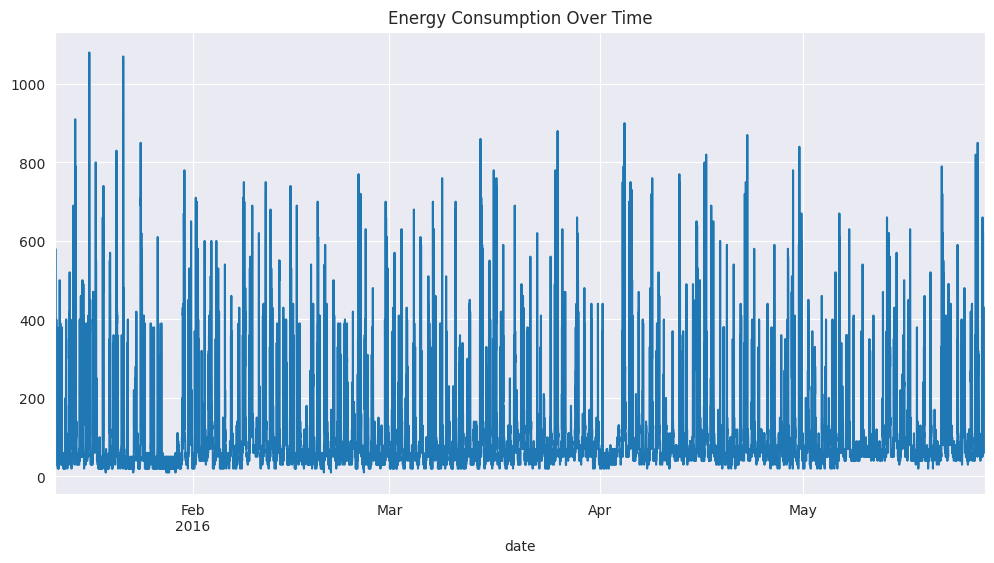

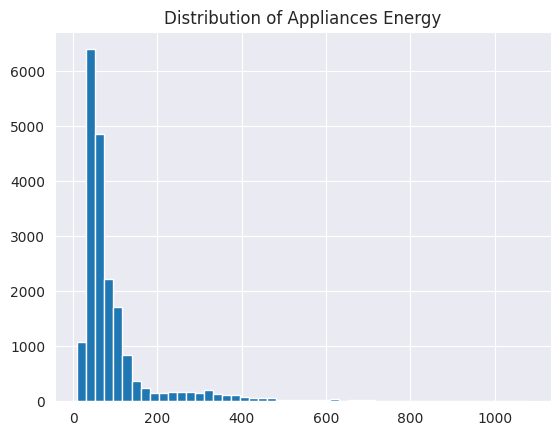

In [74]:
# Plot energy consumption
df['Appliances'].plot(figsize=(12, 6), title='Energy Consumption Over Time')
plt.show()

# Check distribution
df['Appliances'].hist(bins=50)
plt.title('Distribution of Appliances Energy')
plt.show()

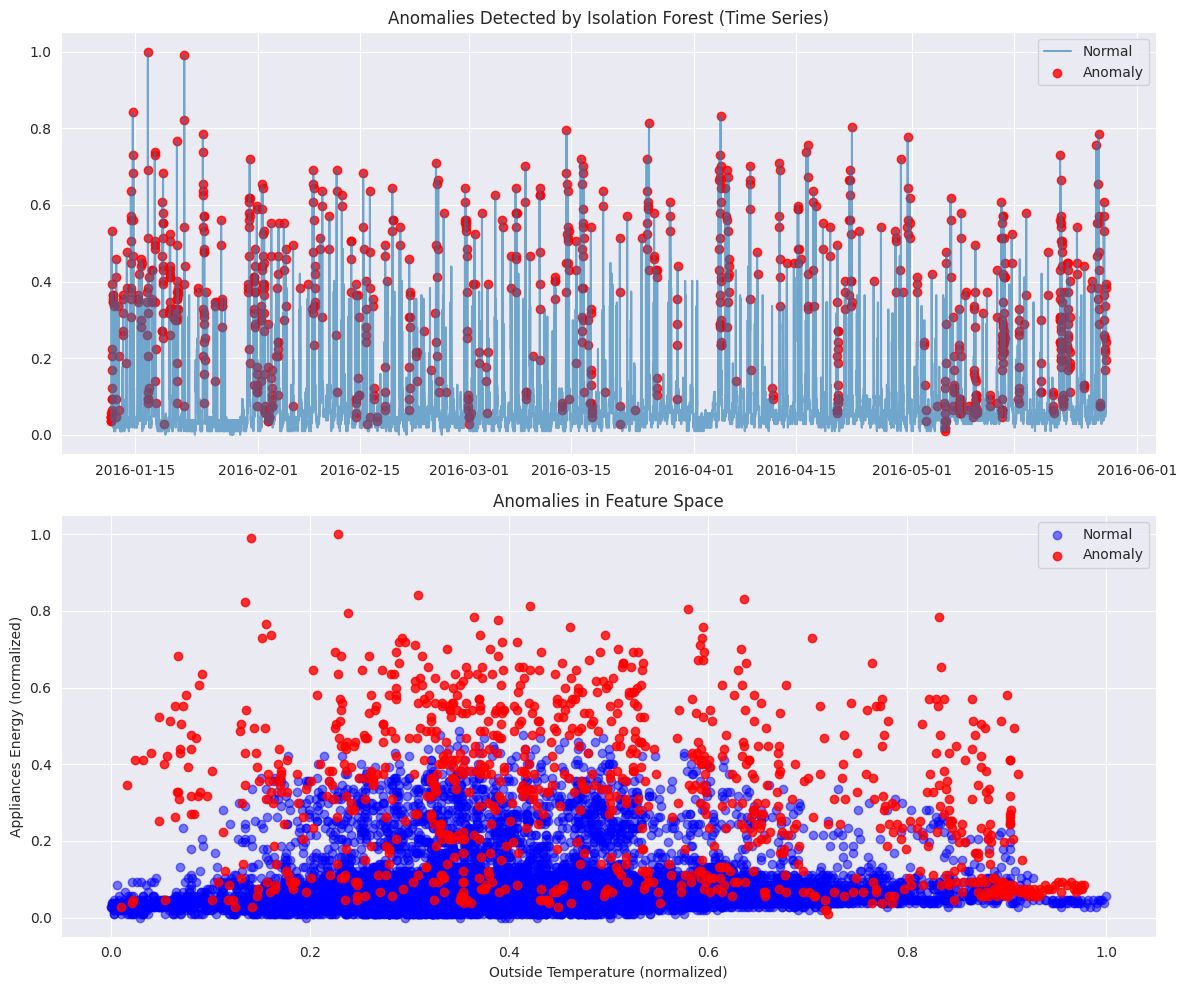

In [75]:
from sklearn.ensemble import IsolationForest

# Train model
model = IsolationForest(contamination=0.05, random_state=42)
df_scaled['anomaly'] = model.fit_predict(
    df_scaled[['Appliances', 'T_out', 'lights', 'RH_1']])  # Use all scaled features

# Visualize anomalies
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Time series plot
ax1.plot(df_scaled.index, df_scaled['Appliances'], label='Normal', alpha=0.6)
ax1.scatter(df_scaled.index[df_scaled['anomaly'] == -1],
            df_scaled['Appliances'][df_scaled['anomaly'] == -1],
            color='red', label='Anomaly', alpha=0.8)
ax1.set_title('Anomalies Detected by Isolation Forest (Time Series)')
ax1.legend()

# Scatter plot of features
ax2.scatter(df_scaled['T_out'][df_scaled['anomaly'] == 1],
            df_scaled['Appliances'][df_scaled['anomaly'] == 1],
            c='blue', label='Normal', alpha=0.5)
ax2.scatter(df_scaled['T_out'][df_scaled['anomaly'] == -1],
            df_scaled['Appliances'][df_scaled['anomaly'] == -1],
            c='red', label='Anomaly', alpha=0.8)
ax2.set_xlabel('Outside Temperature (normalized)')
ax2.set_ylabel('Appliances Energy (normalized)')
ax2.set_title('Anomalies in Feature Space')
ax2.legend()

plt.tight_layout()
plt.show()


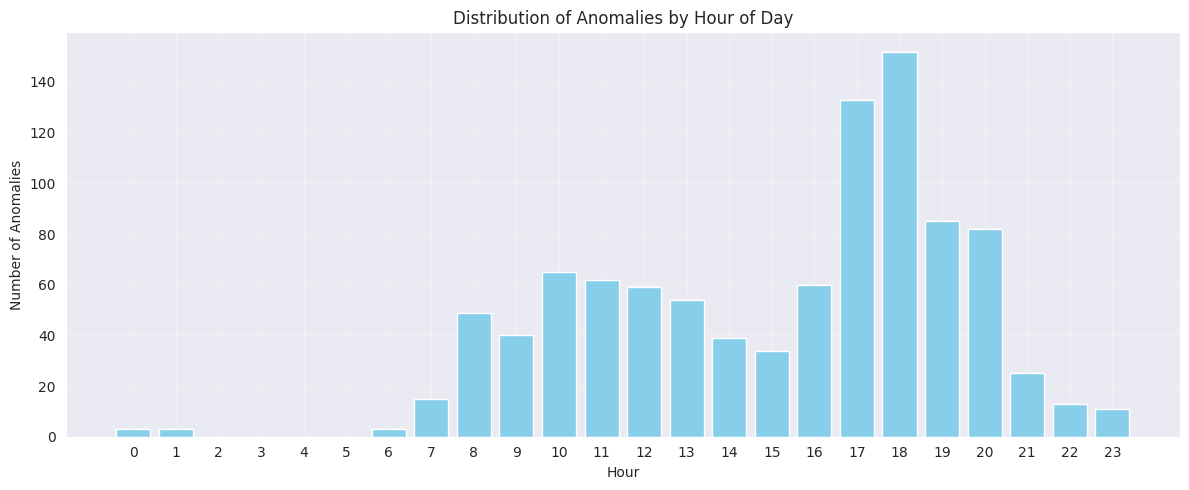


Hourly anomaly distribution:
hour
0       3
1       3
6       3
7      15
8      49
9      40
10     65
11     62
12     59
13     54
14     39
15     34
16     60
17    133
18    152
19     85
20     82
21     25
22     13
23     11
Name: count, dtype: int64


In [76]:
# Analyze anomaly segments by hour
df_scaled['hour'] = df_scaled.index.hour
anomaly_hours = df_scaled[df_scaled['anomaly'] == -1]['hour'].value_counts()

# Create visualizations
plt.figure(figsize=(12, 5))

# Bar plot of anomalies by hour
plt.bar(anomaly_hours.index, anomaly_hours.values, color='skyblue')
plt.title('Distribution of Anomalies by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Anomalies')
plt.grid(True, alpha=0.3)

# Customize x-axis ticks
plt.xticks(range(24))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nHourly anomaly distribution:")
print(anomaly_hours.sort_index())


In [77]:
# Print statistics about detected anomalies
total_points = len(df_scaled)
anomaly_count = (df_scaled['anomaly'] == -1).sum()
anomaly_percentage = (anomaly_count / total_points) * 100

print(f"Total data points: {total_points}")
print(f"Anomalies detected: {anomaly_count}")
print(f"Anomaly percentage: {anomaly_percentage:.2f}%")

# Show top 5 highest energy consumption anomalies
print("\nTop 5 highest energy consumption anomalies:")
# Merge with original (unnormalized) data for actual values
df_with_anomaly = df.copy()
df_with_anomaly['anomaly'] = df_scaled['anomaly']
top_anomalies = df_with_anomaly[df_with_anomaly['anomaly'] == -1].nlargest(5, 'Appliances')
for idx, row in top_anomalies.iterrows():
    print(f"Date: {idx}, Energy: {row['Appliances']:.0f} Wh")

Total data points: 19735
Anomalies detected: 987
Anomaly percentage: 5.00%

Top 5 highest energy consumption anomalies:
Date: 2016-01-16 18:50:00, Energy: 1080 Wh
Date: 2016-01-21 18:50:00, Energy: 1070 Wh
Date: 2016-01-14 17:00:00, Energy: 910 Wh
Date: 2016-04-04 15:40:00, Energy: 900 Wh
Date: 2016-01-21 19:00:00, Energy: 890 Wh


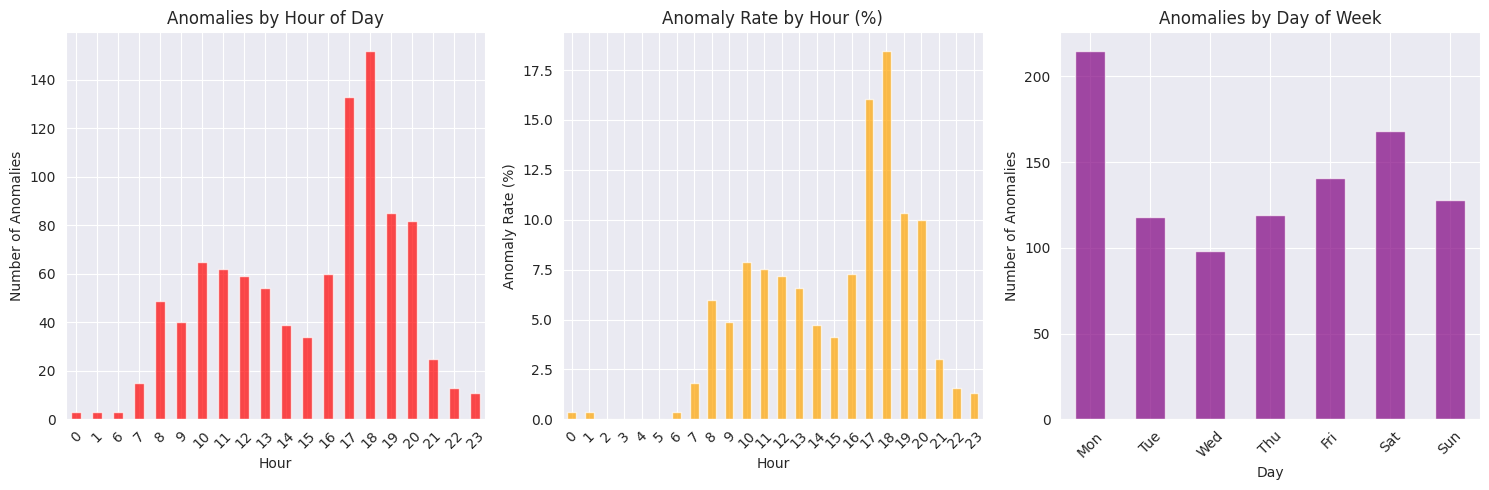

Peak anomaly hours:
hour
18    18.469016
17    16.062802
19    10.340633
20     9.975669
10     7.907543
11     7.542579
16     7.299270
12     7.177616
13     6.569343
8      5.961071
9      4.866180
14     4.744526
15     4.136253
21     3.041363
7      1.824818
22     1.581509
23     1.338200
1      0.364964
0      0.364964
6      0.364964
4      0.000000
5      0.000000
2      0.000000
3      0.000000
dtype: float64


In [87]:
# Temporal analysis of anomalies
df_scaled['hour'] = df_scaled.index.hour
df_scaled['day_of_week'] = df_scaled.index.dayofweek
df_scaled['month'] = df_scaled.index.month

# Analyze anomalies by hour
hourly_anomalies = df_scaled[df_scaled['anomaly'] == -1].groupby('hour').size()
total_by_hour = df_scaled.groupby('hour').size()
hourly_anomaly_rate = (hourly_anomalies / total_by_hour * 100).fillna(0)

# Analyze anomalies by day of week
daily_anomalies = df_scaled[df_scaled['anomaly'] == -1].groupby('day_of_week').size()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(15, 5))

# Plot 1: Absolute count by hour
plt.subplot(1, 3, 1)
hourly_anomalies.plot(kind='bar', color='red', alpha=0.7)
plt.title('Anomalies by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)

# Plot 2: Anomaly rate by hour
plt.subplot(1, 3, 2)
hourly_anomaly_rate.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Anomaly Rate by Hour (%)')
plt.xlabel('Hour')
plt.ylabel('Anomaly Rate (%)')
plt.xticks(rotation=45)

# Plot 3: Anomalies by day of week
plt.subplot(1, 3, 3)
daily_anomalies.index = [day_names[i] for i in daily_anomalies.index]
daily_anomalies.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Anomalies by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Peak anomaly hours:")
print(hourly_anomaly_rate.sort_values(ascending=False))

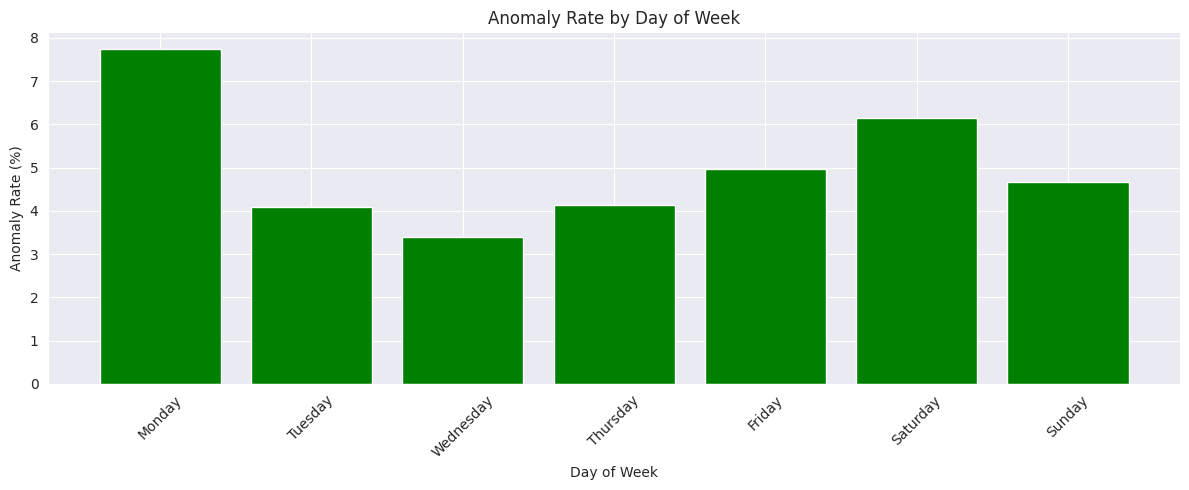

In [79]:
# Add day of week analysis
df_scaled['day_of_week'] = df_scaled.index.dayofweek
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
anomaly_days = df_scaled[df_scaled['anomaly'] == -1]['day_of_week'].value_counts().sort_index()

# Calculate anomaly rate by day
daily_anomaly_rate = {}
for day in range(7):
    total_in_day = (df_scaled['day_of_week'] == day).sum()
    anomalies_in_day = ((df_scaled['day_of_week'] == day) & (df_scaled['anomaly'] == -1)).sum()
    if total_in_day > 0:
        daily_anomaly_rate[days[day]] = (anomalies_in_day / total_in_day) * 100
    else:
        daily_anomaly_rate[days[day]] = 0

# Visualize daily patterns
plt.figure(figsize=(12, 5))
plt.bar(daily_anomaly_rate.keys(), daily_anomaly_rate.values(), color='green')
plt.title('Anomaly Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Anomaly Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [81]:
anomaly_details = df_scaled[df_scaled['anomaly'] == -1].copy()
anomaly_details['timestamp'] = anomaly_details.index
anomaly_details.to_csv('../data/anomaly_details.csv', index=False)
print(f"Saved detailed anomaly information to '../data/anomaly_details.csv'")


Saved detailed anomaly information to '../data/anomaly_details.csv'
